In [115]:
import cv2

# Read the image
image = cv2.imread('car.webp', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [116]:
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


In [117]:
smoothed_image = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0.9)


In [118]:
import numpy as np

height, width = gray_image.shape
edges = []

for y in range(height):
    for x in range(width):
        current_pixel = gray_image[y, x]
        neighbors = [
            (y+dy, x+dx) for dy, dx in [(-1, -1), (-1, 0), (-1, 1), (0, -1),
                                        (0, 1), (1, -1), (1, 0), (1, 1)]
            if 0 <= y+dy < height and 0 <= x+dx < width
        ]
        for ny, nx in neighbors:
            weight = abs(int(current_pixel) - int(gray_image[ny, nx]))
            edges.append(((y, x), (ny, nx), weight))


In [119]:
edges = sorted(edges, key=lambda e: e[2])  # Sort by weight


In [120]:
class UnionFind:
    def __init__(self, size):
        self.parent = list(range(size))
        self.rank = [0] * size

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)
        if root_x != root_y:
            if self.rank[root_x] > self.rank[root_y]:
                self.parent[root_y] = root_x
            elif self.rank[root_x] < self.rank[root_y]:
                self.parent[root_x] = root_y
            else:
                self.parent[root_y] = root_x
                self.rank[root_x] += 1


In [121]:
num_pixels = height * width
uf = UnionFind(num_pixels)


In [122]:
k = 1000
component_size = [1] * num_pixels  # Initialize sizes of components
internal_difference = [0] * num_pixels  # Max edge weight in MST


In [123]:
for (p1, p2, weight) in edges:
    idx1 = p1[0] * width + p1[1]  # Convert (y, x) to a linear index
    idx2 = p2[0] * width + p2[1]

    root1 = uf.find(idx1)
    root2 = uf.find(idx2)

    if root1 != root2:
        threshold1 = internal_difference[root1] + k / component_size[root1]
        threshold2 = internal_difference[root2] + k / component_size[root2]
        min_internal_diff = min(threshold1, threshold2)

        if weight <= min_internal_diff:
            uf.union(root1, root2)
            new_root = uf.find(root1)
            internal_difference[new_root] = max(internal_difference[root1], internal_difference[root2], weight)
            component_size[new_root] = component_size[root1] + component_size[root2]


In [124]:
labels = np.zeros((height, width), dtype=np.int32)
for y in range(height):
    for x in range(width):
        idx = y * width + x
        labels[y, x] = uf.find(idx)


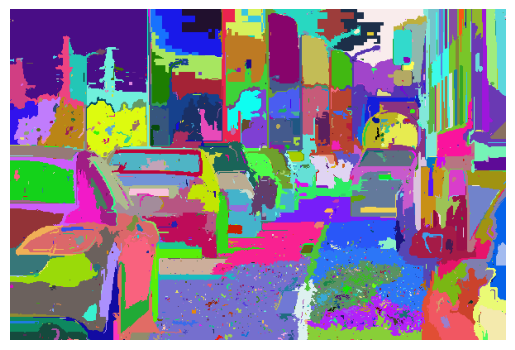

In [125]:
import matplotlib.pyplot as plt

unique_labels = np.unique(labels)
segmented_image = np.zeros_like(image)

for label in unique_labels:
    mask = (labels == label)
    color = np.random.randint(0, 255, 3)  # Random color
    segmented_image[mask] = color

plt.imshow(segmented_image)
plt.axis('off')
plt.show()
